# Medical Diagnosis with Deep Learning on Chest X-Ray

Steps:

- Pre-process and prepare X-ray dataset
- Use transfer learning to retrain a DenseNet model 
- Handle class imbalance
- Measure diagnostic performance by computing the AUC (Area Under the Curve) for the ROC (Receiver Operating Characteristic) curve
- Visualize model activity using GradCAMs


<a name='1'></a>
## 1. Import Packages and Functions¶


In [1]:
import tensorflow
from tensorflow.python.client import device_lib

print("GPU Available:", tensorflow.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
))

print(device_lib.list_local_devices())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10906264744779423413
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12377711899126102278
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6612112652
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11595967371500310811
physical_device_desc: "device: 0, name: Quadro P4000, pci bus id: 0000:65:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5164965837739535831
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
import sys
import numpy as np
#import tensorflow as tf
from datetime import datetime

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

device_name="/gpu:0"

shape=(int(10000),int(10000))

with tf.device(device_name):
    random_matrix = tf.random.uniform(shape=shape, minval=0, maxval=1)
    dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
    sum_operation = tf.reduce_sum(dot_operation)

startTime = datetime.now()
with tf.compat.v1.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        result = session.run(sum_operation)
        print(result)

print("\n" * 2)
print("Shape:", shape, "Device:", device_name)
print("Time taken:", datetime.now() - startTime)

print("\n" * 2)

Instructions for updating:
non-resource variables are not supported in the long term
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro P4000, pci bus id: 0000:65:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

250018170000.0



Shape: (10000, 10000) Device: /gpu:0
Time taken: 0:00:01.266994





In [3]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util

In [4]:
tf.__version__

'2.3.1'

<a name='2'></a>
## Load the Datasets

We will be using the [ChestX-ray8 dataset] which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.

The dataset includes a CSV file that provides the labels for each X-ray. 

In [5]:
file1 = open("Dataset/train_val_list.txt","r+") 
train_val_list = file1.readlines()
train_val_list = [st.rstrip() for st in train_val_list]
file1.close()

#random.seed(0)
#train_list = random.sample(train_val_list, int(len(train_val_list)*0.8))
#val_list = [i for i in train_val_list if i not in train_list]
file1 = open("Dataset/train_list.txt","r+") 
train_list = file1.readlines()
train_list = [st.rstrip() for st in train_list]
file1.close()

file1 = open("Dataset/val_list.txt","r+") 
val_list = file1.readlines()
val_list = [st.rstrip() for st in val_list]
file1.close()

file1 = open("Dataset/test_list.txt","r+") 
test_list = file1.readlines()
test_list = [st.rstrip() for st in test_list]
file1.close()

In [8]:
#MyFile=open('Dataset/train_list.txt','w')

#for element in train_list:
#     MyFile.write(element)
#     MyFile.write('\n')
#MyFile.close()
#
#MyFile=open('Dataset/val_list.txt','w')
#
#for element in val_list:
#     MyFile.write(element)
#     MyFile.write('\n')
#MyFile.close()

In [6]:
len(train_val_list), len(test_list)

(86524, 25596)

In [7]:
main_df = pd.read_csv("Dataset/Data_Entry_2017 - Encoded CSV.csv")

main_df.rename(columns = {"Patient ID": "PatientId", 'Image Index': 'Image'},  
          inplace = True) 

train_df = main_df[main_df.Image.isin(train_list)]
valid_df = main_df[main_df.Image.isin(val_list)]
test_df = main_df[main_df.Image.isin(test_list)]
#valid_df = pd.read_csv("nih/valid-small.csv")
#test_df = pd.read_csv("nih/test.csv")

train_df.head()

,Image,Finding Labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,...,Pneumothorax,Follow-up #,PatientId,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,0,0,0,0,0,0,...,0,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,0,1,0,0,0,1,0,0,...,0,1,1,58,M,PA,2894,2729,0.143,0.143
3,00000002_000.png,No Finding,0,0,0,0,0,0,0,0,...,0,0,2,81,M,PA,2500,2048,0.171,0.171
12,00000004_000.png,Mass|Nodule,0,0,0,0,0,0,0,0,...,0,0,4,82,M,AP,2500,2048,0.168,0.168
16,00000005_003.png,No Finding,0,0,0,0,0,0,0,0,...,0,3,5,69,F,PA,2992,2991,0.143,0.143


In [8]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

<a name='2-1'></a>
### Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

<a name='Ex-1'></a>
### Checking Data Leakage
In the cell below, write a function to check whether there is leakage between two datasets. We'll use this to make sure there are no patients in the test set that are also present in either the train or validation sets.

In [9]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
 
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) > 0 # boolean (true if there is at least 1 patient in both groups)
    
    return leakage

In [10]:
# test
print("test case 1")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [2, 3, 4]})
print("df1")
print(df1)
print("df2")
print(df2)
print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}")
print("-------------------------------------")
print("test case 2")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [3, 4, 5]})
print("df1:")
print(df1)
print("df2:")
print(df2)

print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}")

test case 1
df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           3
2           4
leakage output: True
-------------------------------------
test case 2
df1:
   patient_id
0           0
1           1
2           2
df2:
   patient_id
0           3
1           4
2           5
leakage output: False


Run the next cell to check if there are patients in both train and test or in both valid and test.

In [11]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


<a name='2-2'></a>
### 2.2 Preparing Images

In [12]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [13]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

With our generator function ready, let's make one generator for our training data and one each of our test and  validation datasets.

In [14]:
IMAGE_DIR = "Dataset/all_images/"#"nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 69219 validated image filenames.
getting train and valid generators...
Found 69219 validated image filenames.
Found 17305 validated image filenames.
Found 25596 validated image filenames.


Let's peek into what the generator gives our model during training and validation. We can do this by calling the `__get_item__(index)` function:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


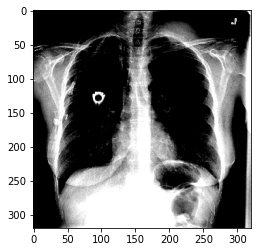

In [15]:
x, y = train_generator.__getitem__(5065)
plt.imshow(x[0]);

<a name='3'></a>
## Model Development


<a name='3-1'></a>
### Addressing Class Imbalance

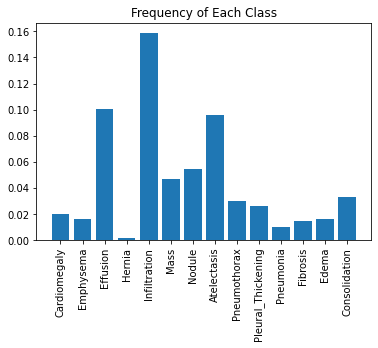

In [16]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

<a name='Ex-2'></a>
### Computing Class Frequencies


We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss. 

In [17]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

In [18]:
# Test
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
print("labels:")
print(labels_matrix)

test_pos_freqs, test_neg_freqs = compute_class_freqs(labels_matrix)

print(f"pos freqs: {test_pos_freqs}")

print(f"neg freqs: {test_neg_freqs}")

labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]


Now we'll compute frequencies for our training data.

In [19]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.01963334, 0.01648391, 0.10047819, 0.00160361, 0.15878588,
       0.04683685, 0.05481154, 0.09582629, 0.03000621, 0.02583106,
       0.00999726, 0.01450469, 0.0158338 , 0.03304006])

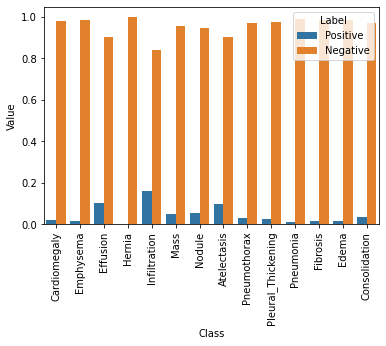

In [20]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

Let's visualize these two contribution ratios next to each other for each of the pathologies:

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [21]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Let's verify this by graphing the two contributions next to each other again:

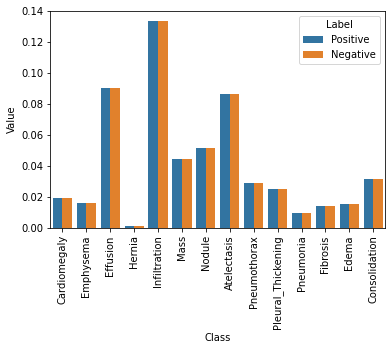

In [22]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function. 

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

<a name='Ex-3'></a>
### Weighted Loss
Fill out the `weighted_loss` function below to return a loss function that calculates the weighted loss for each batch. Recall that for the multi-class loss, we add up the average loss for each individual class. Note that we also want to add a small value, $\epsilon$, to the predicted values before taking their logs. This is simply to avoid a numerical error that would otherwise occur if the predicted value happens to be zero.



In [25]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        
        return loss
    
    return weighted_loss

<a name='3-3'></a>
### DenseNet121

Next, we will use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

We can set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [26]:
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

<a name='4'></a>
## Training



Epoch 1/100
1000/1000 [==============================] - 276s 276ms/step - batch: 499.5000 - size: 8.0000 - loss: 0.7357 - val_loss: 0.8444
Epoch 2/100
1000/1000 [==============================] - 272s 272ms/step - batch: 499.5000 - size: 8.0000 - loss: 0.7234 - val_loss: 0.8045
Epoch 3/100
1000/1000 [==============================] - 269s 269ms/step - batch: 499.5000 - size: 8.0000 - loss: 0.7336 - val_loss: 0.7908
Epoch 4/100
1000/1000 [==============================] - 270s 270ms/step - batch: 499.5000 - size: 8.0000 - loss: 0.7363 - val_loss: 0.7682
Epoch 5/100
1000/1000 [==============================] - 269s 269ms/step - batch: 499.5000 - size: 8.0000 - loss: 0.7378 - val_loss: 1.3073
Epoch 6/100
1000/1000 [==============================] - 290s 290ms/step - batch: 499.5000 - size: 8.0000 - loss: 0.7295 - val_loss: 0.7852
Epoch 7/100
1000/1000 [==============================] - 299s 299ms/step - batch: 499.5000 - size: 8.0000 - loss: 0.7281 - val_loss: 0.7551
Epoch 8/100
1000/100

1000/1000 [==============================] - 290s 290ms/step - batch: 499.5000 - size: 8.0000 - loss: 0.6536 - val_loss: 0.7121
Epoch 60/100
1000/1000 [==============================] - 300s 300ms/step - batch: 499.5000 - size: 8.0000 - loss: 0.6587 - val_loss: 0.7440
Epoch 61/100
1000/1000 [==============================] - 277s 277ms/step - batch: 499.5000 - size: 8.0000 - loss: 0.6544 - val_loss: 0.6683
Epoch 62/100
1000/1000 [==============================] - 251s 251ms/step - batch: 499.5000 - size: 8.0000 - loss: 0.6495 - val_loss: 0.7159
Epoch 63/100
1000/1000 [==============================] - 251s 251ms/step - batch: 499.5000 - size: 8.0000 - loss: 0.6423 - val_loss: 0.7381
Epoch 64/100
1000/1000 [==============================] - 250s 250ms/step - batch: 499.5000 - size: 8.0000 - loss: 0.6517 - val_loss: 0.7907
Epoch 65/100
1000/1000 [==============================] - 250s 250ms/step - batch: 499.5000 - size: 8.0000 - loss: 0.6448 - val_loss: 0.6881
Epoch 66/100
1000/1000 [==

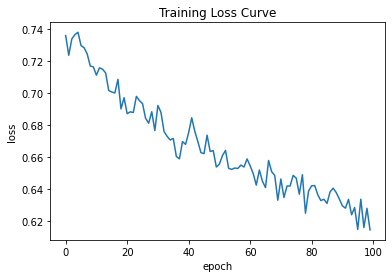

In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=1000, 
                              validation_steps=25, callbacks=[reduce_lr],
                              epochs = 100)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [36]:
model.save("imagenet14Dec")

In [27]:
model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights("imagenet14Dec")

<a name='5'></a>
## Prediction and Evaluation

In [30]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

Instructions for updating:
Please use Model.predict, which supports generators.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [35]:
#predicted_vals2 = model2.predict_generator(test_generator, steps = len(test_generator))

In [33]:
#model.load_weights("./nih/pretrained_model.h5")

<a name='5-1'></a>
### ROC Curve and AUROC

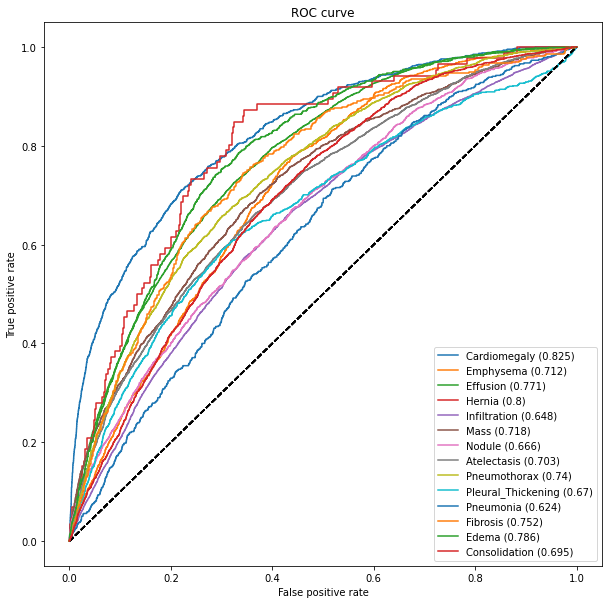

In [31]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

You can compare the performance to the AUCs reported in the original ChexNeXt paper in the table below: 

For reference, here's the AUC figure from the ChexNeXt paper which includes AUC values for their model as well as radiologists on this dataset:

<img src="https://journals.plos.org/plosmedicine/article/figure/image?size=large&id=10.1371/journal.pmed.1002686.t001" width="80%">

This method does take advantage of a few other tricks such as self-training and ensembling as well, which can give a significant boost to the performance.

<a name='5-2'></a>
### Visualizing Learning with GradCAM 


First we will load the small training set and setup to look at the 4 classes with the highest performing AUC measures.

In [38]:
df = test_df#pd.read_csv("nih/train-small.csv")
IMAGE_DIR = "Dataset/all_images/"#"nih/images-small/"

# only show the lables with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

Now let's look at a few specific images.

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Generating gradcam for class Edema


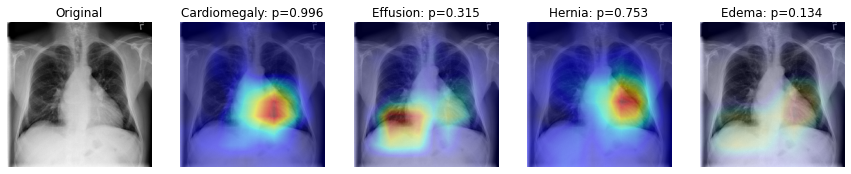

In [44]:
util.compute_gradcam(model, '00000001_000.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Generating gradcam for class Fibrosis
Generating gradcam for class Consolidation


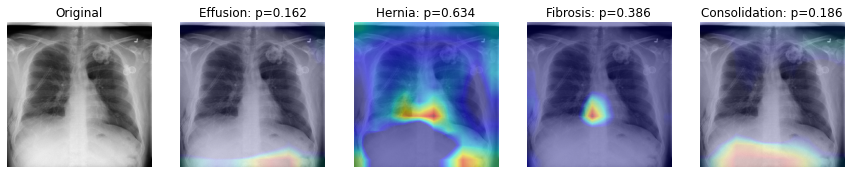

In [39]:
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Generating gradcam for class Fibrosis
Generating gradcam for class Consolidation


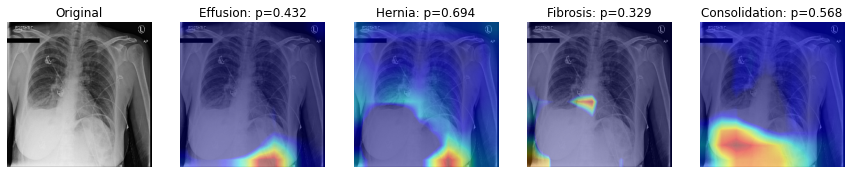

In [40]:
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Generating gradcam for class Edema


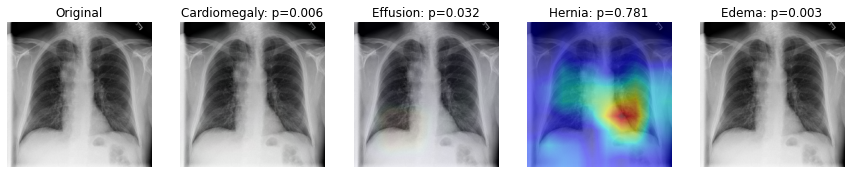

In [40]:
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Generating gradcam for class Edema


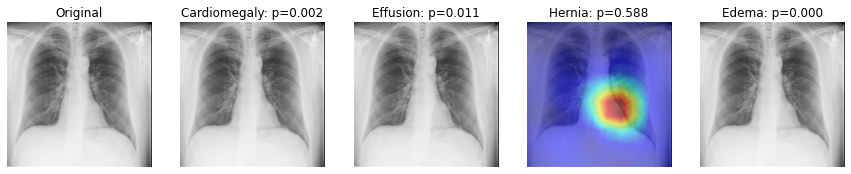

In [43]:
util.compute_gradcam(model, '00006510_000.png', IMAGE_DIR, df, labels, labels_to_show)